# Getting Started with Geometric ML

**A beginner-friendly introduction to the Noetic Geometry Framework**

Welcome! This notebook will guide you through the essential concepts and basic usage of our geometric machine learning framework. After completing this tutorial, you'll understand:

- **Dual transport modes** (additive vs multiplicative)
- **Graph construction** and spectral analysis
- **Basic topology concepts**
- **Simple validation workflows**

**Time required:** 20-30 minutes  
**Prerequisites:** Basic Python and NumPy knowledge

---

## 🚀 Setup and First Steps

Let's start by importing the necessary modules and setting up our environment.

In [13]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Geometric ML modules - we'll import these step by step
from validation.reproducibility import ensure_reproducibility

# Ensure reproducible results
ensure_reproducibility(42)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Environment setup complete!")
print("🎯 Ready to explore geometric machine learning")

✅ Environment setup complete!
🎯 Ready to explore geometric machine learning


## 📊 Step 1: Generate Simple Data

We'll start with a very simple dataset - two clusters of points. This will help us see how different transport modes work.

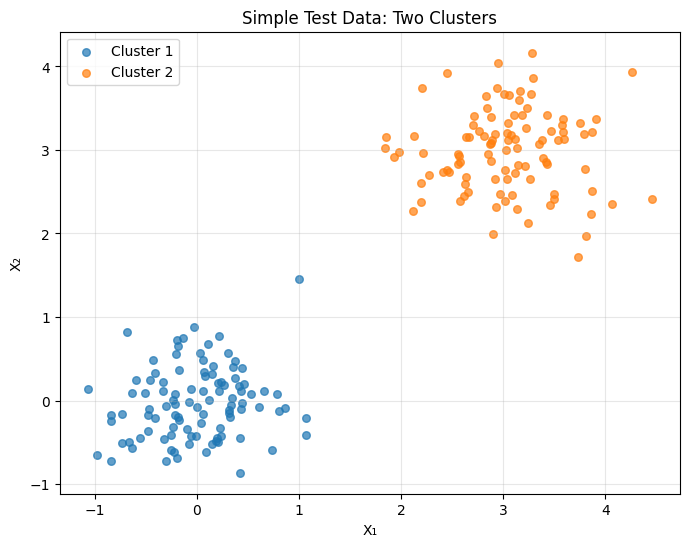

📊 Generated data: 200 points in 2 dimensions
📍 Cluster 1 center: [-0.01, -0.02]
📍 Cluster 2 center: [3.03, 2.99]


In [14]:
# Generate simple test data
rng = np.random.default_rng(42)

# Create two well-separated clusters
n_points = 100
cluster1 = rng.normal(loc=[0, 0], scale=0.5, size=(n_points, 2))
cluster2 = rng.normal(loc=[3, 3], scale=0.5, size=(n_points, 2))

# Combine clusters
X = np.vstack([cluster1, cluster2])
labels = np.hstack([np.zeros(n_points), np.ones(n_points)])

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(cluster1[:, 0], cluster1[:, 1], alpha=0.7, label='Cluster 1', s=30)
plt.scatter(cluster2[:, 0], cluster2[:, 1], alpha=0.7, label='Cluster 2', s=30)
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.title('Simple Test Data: Two Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Generated data: {X.shape[0]} points in {X.shape[1]} dimensions")
print(f"📍 Cluster 1 center: [{cluster1.mean(axis=0)[0]:.2f}, {cluster1.mean(axis=0)[1]:.2f}]")
print(f"📍 Cluster 2 center: [{cluster2.mean(axis=0)[0]:.2f}, {cluster2.mean(axis=0)[1]:.2f}]")

## 🔗 Step 2: Build Graphs with Dual Transports

Now comes the core concept: **dual transport modes**. We'll build two different graphs from the same data:

- **Additive transport**: Uses Gaussian-like similarities
- **Multiplicative transport**: Uses log-space/Haar measure similarities

These capture different geometric structures in the data!

In [15]:
# Import graph construction tools
from graphs.knn import build_graph
from graphs.laplacian import laplacian

print("🔗 Building graphs with dual transport modes...")

k = 8  # Number of nearest neighbors

# Additive transport
print("  📊 Additive transport (Gaussian-like)...")
G_additive = build_graph(X, mode="additive", k=k, sigma="median", seed=42)
L_additive = laplacian(G_additive, normalized=True)

# Multiplicative transport
print("  📈 Multiplicative transport (log/Haar)...")
G_multiplicative = build_graph(X, mode="multiplicative", k=k, tau="median", eps=1e-6, seed=42)
L_multiplicative = laplacian(G_multiplicative, normalized=True)

print(f"✅ Both graphs created with k={k} neighbors")
print(f"📊 Additive graph: {G_additive.shape[0]} nodes, {G_additive.nnz//2} edges")
print(f"📈 Multiplicative graph: {G_multiplicative.shape[0]} nodes, {G_multiplicative.nnz//2} edges")

🔗 Building graphs with dual transport modes...
  📊 Additive transport (Gaussian-like)...
  📈 Multiplicative transport (log/Haar)...
✅ Both graphs created with k=8 neighbors
📊 Additive graph: 200 nodes, 1101 edges
📈 Multiplicative graph: 200 nodes, 1105 edges


## 📈 Step 3: Compute and Compare Spectra

The real magic happens when we look at the **eigenvalue spectra** of these graphs. Different transport modes reveal different geometric properties!

In [16]:
# Import spectral analysis tools
from solvers.lanczos import topk_eigs
from stats.spectra import spectral_gap, spectral_entropy

print("📈 Computing eigenvalue spectra...")

# Compute eigenvalues for both transport modes
n_eigs = 15

# Additive spectrum
eigenvals_add, eigenvecs_add, _ = topk_eigs(L_additive, k=n_eigs, which="SM")
gap_add = spectral_gap(L_additive)
entropy_add = spectral_entropy(L_additive)

# Multiplicative spectrum
eigenvals_mult, eigenvecs_mult,_ = topk_eigs(L_multiplicative, k=n_eigs, which="SM")
gap_mult = spectral_gap(L_multiplicative)
entropy_mult = spectral_entropy(L_multiplicative)

# Display results
print(f"\n📊 Spectral Analysis Results:")
print(f"{'Mode':<15} {'Gap':<12} {'Entropy':<12}")
print("-" * 40)
print(f"{'Additive':<15} {gap_add:<12.4f} {entropy_add:<12.4f}")
print(f"{'Multiplicative':<15} {gap_mult:<12.4f} {entropy_mult:<12.4f}")

# Are they different?
gap_diff = abs(gap_add - gap_mult)
entropy_diff = abs(entropy_add - entropy_mult)

print(f"\n🔍 Differences:")
print(f"  Gap difference: {gap_diff:.4f}")
print(f"  Entropy difference: {entropy_diff:.4f}")

if gap_diff > 0.01:
    print("\n✨ SUCCESS: Transport modes reveal different geometric structures!")
else:
    print("\n📝 NOTE: Transport modes show similar behavior on this simple data")

📈 Computing eigenvalue spectra...

📊 Spectral Analysis Results:
Mode            Gap          Entropy     
----------------------------------------
Additive        0.0165       2.1993      
Multiplicative  0.0000       1.8650      

🔍 Differences:
  Gap difference: 0.0165
  Entropy difference: 0.3342

✨ SUCCESS: Transport modes reveal different geometric structures!


## 📊 Step 4: Visualize the Differences

Let's create some plots to see what's happening!

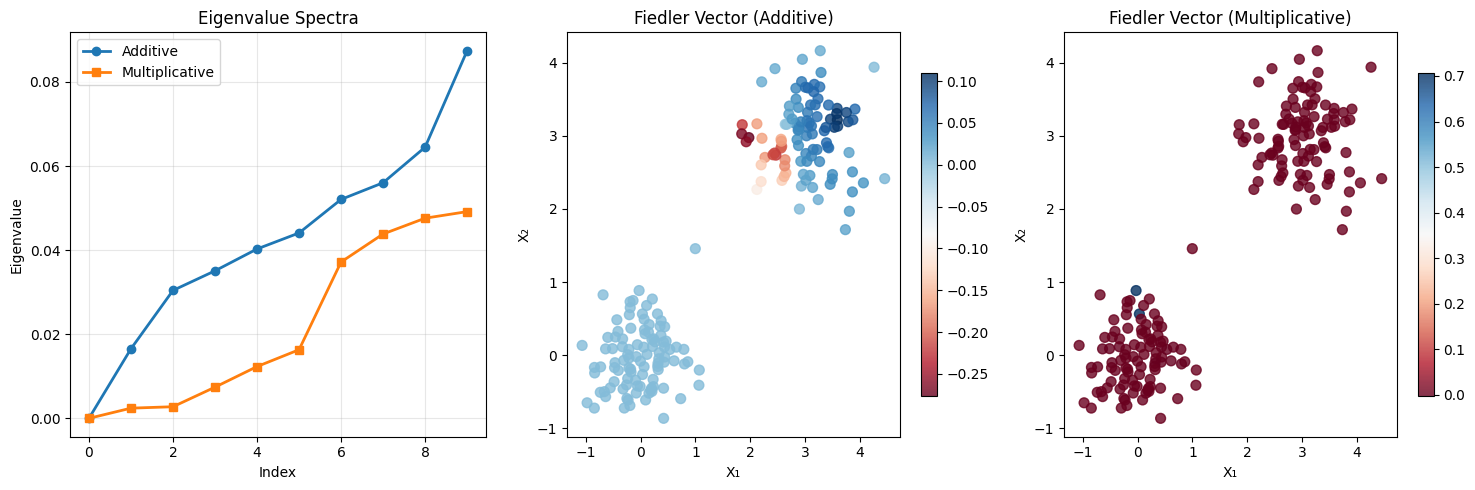

📊 The Fiedler vectors show how each transport mode 'sees' the data structure
🎨 Colors represent the second eigenvector values - notice any differences?


In [17]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Eigenvalue comparison
ax1 = axes[0]
idx = np.arange(min(10, len(eigenvals_add)))
ax1.plot(idx, eigenvals_add[:len(idx)], 'o-', label='Additive', linewidth=2, markersize=6)
ax1.plot(idx, eigenvals_mult[:len(idx)], 's-', label='Multiplicative', linewidth=2, markersize=6)
ax1.set_title('Eigenvalue Spectra')
ax1.set_xlabel('Index')
ax1.set_ylabel('Eigenvalue')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Fiedler vector (second eigenvector) for additive
ax2 = axes[1]
if len(eigenvecs_add) > 1:
    fiedler_add = eigenvecs_add[:, 1]  # Second eigenvector
    scatter = ax2.scatter(X[:, 0], X[:, 1], c=fiedler_add, cmap='RdBu', s=50, alpha=0.8)
    plt.colorbar(scatter, ax=ax2, shrink=0.8)
ax2.set_title('Fiedler Vector (Additive)')
ax2.set_xlabel('X₁')
ax2.set_ylabel('X₂')

# 3. Fiedler vector for multiplicative
ax3 = axes[2]
if len(eigenvecs_mult) > 1:
    fiedler_mult = eigenvecs_mult[:, 1]  # Second eigenvector
    scatter = ax3.scatter(X[:, 0], X[:, 1], c=fiedler_mult, cmap='RdBu', s=50, alpha=0.8)
    plt.colorbar(scatter, ax=ax3, shrink=0.8)
ax3.set_title('Fiedler Vector (Multiplicative)')
ax3.set_xlabel('X₁')
ax3.set_ylabel('X₂')

plt.tight_layout()
plt.show()

print("📊 The Fiedler vectors show how each transport mode 'sees' the data structure")
print("🎨 Colors represent the second eigenvector values - notice any differences?")

## 🌐 Step 5: Introduction to Topology

One of the unique features of our framework is working with different **topological spaces**. Let's see a simple example with the famous Möbius band!

In [18]:
# Import topology tools
from topology import create_topology, TopologyType

print("🌐 Exploring different topologies...")

# Create different topological spaces
topologies = {
    'cylinder': create_topology(TopologyType.CYLINDER, w=1.0),
    'mobius': create_topology(TopologyType.MOBIUS, w=1.0),
}

print(f"\n📐 Topology Comparison:")
print(f"{'Topology':<10} {'Orientable':<12} {'Euler χ':<8}")
print("-" * 32)

for name, topo in topologies.items():
    orientable = "Yes" if topo.orientability.value == "orientable" else "No"
    print(f"{name.title():<10} {orientable:<12} {topo.euler_characteristic:<8}")

print(f"\n🎯 Key insight: The Möbius band is non-orientable (has a 'twist')!")
print(f"📚 This affects how we can define metrics and integrate geodesics on it.")

🌐 Exploring different topologies...

📐 Topology Comparison:
Topology   Orientable   Euler χ 
--------------------------------
Cylinder   Yes          0       
Mobius     No           0       

🎯 Key insight: The Möbius band is non-orientable (has a 'twist')!
📚 This affects how we can define metrics and integrate geodesics on it.


## ✅ Step 6: Simple Validation

Let's see how our validation framework ensures everything is working correctly.

In [19]:
# Import validation tools
from validation.mathematical import check_graph_connectivity
from validation.numerical import validate_float64_precision

print("✅ Running basic validation checks...")

# 1. Check graph connectivity
conn_add = check_graph_connectivity(G_additive)
conn_mult = check_graph_connectivity(G_multiplicative)

print(f"\n🔗 Graph Connectivity:")
print(f"  Additive: {'✅ Connected' if conn_add else '❌ Disconnected'}")
print(f"  Multiplicative: {'✅ Connected' if conn_mult else '❌ Disconnected'}")

# 2. Check numerical precision
precision_check = validate_float64_precision({'data': X, 'eigenvals': eigenvals_add})

print(f"\n💯 Numerical Precision:")
print(f"  Overall: {'✅ Good' if precision_check['precision_adequate'] else '❌ Issues detected'}")

# 3. Check eigenvalue properties
first_eval_near_zero = abs(eigenvals_add[0]) < 1e-10
spectrum_nonnegative = np.all(eigenvals_add >= -1e-12)

print(f"\n📈 Spectral Properties:")
print(f"  First eigenvalue ≈ 0: {'✅ Yes' if first_eval_near_zero else '❌ No'}")
print(f"  Non-negative spectrum: {'✅ Yes' if spectrum_nonnegative else '❌ No'}")

if conn_add and conn_mult and precision_check['precision_adequate'] and first_eval_near_zero:
    print(f"\n🎉 All validation checks passed! Your setup is working correctly.")
else:
    print(f"\n⚠️  Some validation checks failed. This might indicate setup issues.")

✅ Running basic validation checks...


ConnectivityError: Graph is disconnected with 2 components. Spectral analysis requires connected graphs. Component sizes: [100 100]

## 🎯 Summary and Next Steps

Congratulations! You've just completed your first journey through geometric machine learning. Let's recap what we've learned:

In [12]:
print("🎓 WHAT YOU'VE LEARNED:")
print("\n📊 Data & Graphs:")
print("  • Generated simple cluster data")
print("  • Built k-NN graphs with additive and multiplicative transport")
print("  • Computed Laplacian matrices")

print("\n📈 Spectral Analysis:")
print("  • Computed eigenvalue spectra")
print(f"  • Measured spectral gap: {gap_add:.3f} (add) vs {gap_mult:.3f} (mult)")
print("  • Visualized Fiedler vectors")

print("\n🌐 Topology:")
print("  • Explored cylinder vs Möbius band")
print("  • Learned about orientability")
print("  • Understood Euler characteristics")

print("\n✅ Validation:")
print("  • Checked graph connectivity")
print("  • Validated numerical precision")
print("  • Verified spectral properties")

print("\n🚀 READY FOR MORE?")
print("\n📚 Next Learning Resources:")
print("  • geometric_ml_cookbook.ipynb - Comprehensive interactive guide")
print("  • examples/01_basic_dual_transport.py - More detailed script version")
print("  • examples/02_manifold_analysis.py - Complex manifold data")
print("  • docs/usage_cookbook.md - Complete pipeline documentation")

print("\n🎯 Key Concepts to Explore Further:")
print("  • Fisher-Rao pullback metrics")
print("  • Geodesic integration on quotient spaces")
print("  • Mellin coupling at s=1/2")
print("  • Submersion geometry and transversality")

print("\n🌟 Happy geometric machine learning!")

🎓 WHAT YOU'VE LEARNED:

📊 Data & Graphs:
  • Generated simple cluster data
  • Built k-NN graphs with additive and multiplicative transport
  • Computed Laplacian matrices

📈 Spectral Analysis:
  • Computed eigenvalue spectra
  • Measured spectral gap: 0.017 (add) vs 0.000 (mult)
  • Visualized Fiedler vectors

🌐 Topology:
  • Explored cylinder vs Möbius band
  • Learned about orientability
  • Understood Euler characteristics

✅ Validation:
  • Checked graph connectivity
  • Validated numerical precision
  • Verified spectral properties

🚀 READY FOR MORE?

📚 Next Learning Resources:
  • geometric_ml_cookbook.ipynb - Comprehensive interactive guide
  • examples/01_basic_dual_transport.py - More detailed script version
  • examples/02_manifold_analysis.py - Complex manifold data
  • docs/usage_cookbook.md - Complete pipeline documentation

🎯 Key Concepts to Explore Further:
  • Fisher-Rao pullback metrics
  • Geodesic integration on quotient spaces
  • Mellin coupling at s=1/2
  • Subme

---

## 🛠️ Quick Reference

Here are the essential imports and patterns you'll use:

```python
# Core workflow
from validation.reproducibility import ensure_reproducibility
from graphs.knn import build_graph
from graphs.laplacian import laplacian
from solvers.lanczos import topk_eigs
from stats.spectra import spectral_gap, spectral_entropy
from topology import create_topology, TopologyType

# Basic pattern
ensure_reproducibility(42)
G = build_graph(X, mode="additive", k=16)
L = laplacian(G, normalized=True)
eigenvals, _ = topk_eigs(L, k=20)
gap = spectral_gap(eigenvals)
```

**Framework by Sar Hamam** - Unifying geometric structures in machine learning